# 7 Pairwise LETOR: Microsoft `lightgbm` implementation of `LambdaMART`

This notebook shows how to implement `LambdaMART` with the efficient Microsoft implementation of `xgboost`, `lightgbm`. Here we use this algo first with toy data and next, we translate to the stock ranking problem with monthly rebalancing.

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  PATH = "/content/drive/MyDrive/"
  PATH_INSTALL_REQUIREMENTS = "/content/drive/MyDrive/Colab\ Notebooks/requirements.txt"  
  import sys
  sys.path.append(PATH + "Colab Notebooks")
except:  
  import os
  if os.name=="nt":
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "\\requirements.txt"  
  else: #Unix system
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "/requirements.txt"  
  PATH=""

In [2]:
%pip install -r {PATH_INSTALL_REQUIREMENTS}

import optuna
import joblib

import numpy as np
import pandas as pd
import lightgbm as lightgbm
import optuna.integration.lightgbm as optuna_lgb

from collections import OrderedDict
from sklearn.model_selection import ParameterGrid

Note: you may need to restart the kernel to use updated packages.


## Learning Pairwise G11 Currency Ratings

### 1. Loading the Data

**Potential (Quantized) Targets**


In [3]:
targets = pd.read_csv(
    PATH + "fx_data/20220929_FX_quantized_targets.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [5]:
targets.head()

,symbols,RET1DAH,ISR1M,ISR3M,ISR6M
Date,,,,,
2004-05-24,AUD,10,1,2,3
2004-05-24,CAD,1,4,5,1
2004-05-24,CHF,3,10,9,9
2004-05-24,DKK,5,9,8,8
2004-05-24,GBP,7,6,3,10


**Initial Features**

In [7]:
predictors = pd.read_csv(
    PATH + "fx_data/20220930_FX_features.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [8]:
predictors.head()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466


Merge features with relevances (`ISR3M` as output)

In [9]:
data = pd.merge(    
        predictors,
        targets[["symbols","ISR3M"]],
    on=["Date","symbols"],
    how="inner"
)


In [10]:

data.rename(columns={"ISR3M_y": "observed_rank"}, inplace=True)
data

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,observed_rank
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331,2
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748,4
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825,9
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638,8
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29,JPY,0.012121,0.017806,-0.007876,0.005136,0.113193,-1.341665,-0.677560,0.760193,0.789695,...,12.774060,6.966194,3.497260,-0.008030,0.350248,-5.904901e-03,0.881938,1.038133,0.909191,6
2022-09-29,NOK,-0.018502,-0.030445,-0.053177,-0.003796,0.104257,-0.321431,-1.079341,-1.259888,-1.465918,...,11.805635,6.943473,3.380327,-0.065416,-0.000728,-1.287023e-02,0.388800,0.984594,0.778895,1
2022-09-29,NZD,-0.006492,-0.022662,-0.037018,-0.010162,0.084419,0.687908,-0.684954,-0.545918,-1.347578,...,11.090927,6.769747,3.453289,-0.031333,-0.002428,-1.078672e-02,0.369109,0.936174,0.763040,3


In [11]:
# Dumping for Archive
data.to_csv(
    PATH + "fx_data/20220929_letor_FX_daily_relevances.csv",
    
)

### 2. Splitting the data intro train and test

In [12]:
data

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,observed_rank
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331,2
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748,4
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825,9
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638,8
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-29,JPY,0.012121,0.017806,-0.007876,0.005136,0.113193,-1.341665,-0.677560,0.760193,0.789695,...,12.774060,6.966194,3.497260,-0.008030,0.350248,-5.904901e-03,0.881938,1.038133,0.909191,6
2022-09-29,NOK,-0.018502,-0.030445,-0.053177,-0.003796,0.104257,-0.321431,-1.079341,-1.259888,-1.465918,...,11.805635,6.943473,3.380327,-0.065416,-0.000728,-1.287023e-02,0.388800,0.984594,0.778895,1
2022-09-29,NZD,-0.006492,-0.022662,-0.037018,-0.010162,0.084419,0.687908,-0.684954,-0.545918,-1.347578,...,11.090927,6.769747,3.453289,-0.031333,-0.002428,-1.078672e-02,0.369109,0.936174,0.763040,3


In [13]:
train = data[:"2018"]
test = data["2019":]

In [14]:
print(f"Train/Total Prcnt Split {100*train.shape[0]/data.shape[0]:.2f}%")

Train/Total Prcnt Split 79.45%


In [15]:
train.tail(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,observed_rank
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,JPY,0.000341,0.015406,0.023311,0.039169,0.068112,0.958100,-0.263260,0.035499,1.135443,...,25.910436,9.897034,3.989189,10.573045,4.021342,1.024691,2.186265,1.454315,1.114922,10
2018-12-31,NOK,0.001247,-0.021955,-0.024044,-0.052596,0.060208,1.442600,0.367086,0.147021,-1.830548,...,10.474178,6.250253,3.375089,-0.018078,-0.010236,-0.004653,0.475308,0.505669,0.706600,2
2018-12-31,NZD,-0.007301,-0.024313,-0.027104,0.028025,0.086974,0.100608,-0.634025,-0.595942,-1.403298,...,22.298551,9.786237,4.426369,-0.027664,1.937340,0.399160,0.601019,1.237701,1.047407,8
2018-12-31,SEK,0.000840,-0.003125,0.005169,0.012791,0.059882,0.691579,0.754762,0.099591,-0.261942,...,13.671854,7.324387,3.447077,1.458125,1.384202,-0.000100,1.156082,1.150455,0.993588,9
2018-12-31,USD,-0.005868,-0.011713,-0.004124,0.009773,0.064648,-0.190858,-0.302625,-0.644430,-0.909517,...,30.502123,10.887670,4.227297,-0.001967,0.966508,1.064030,0.884290,1.104506,1.118376,5


In [18]:
print(f"# unique potential daily rebalance dates in train : {train.index.nunique()}")
print(f"# unique potential daily rebalance dates in test : {test.index.nunique()}")
print(f"Fraction : {100*train.index.nunique()/data.index.nunique():.1f}%")

# unique potential daily rebalance dates in train : 3777
# unique potential daily rebalance dates in test : 977
Fraction : 79.4%


### 3. Preparing the data for `LightGBM`

Before we move on to train the `LightGBM` `LambdaMART` on our FX data, we would need to split the data into the features and the relevance label which are essentially called `(X_train ,y_train)` for training set and `(X_test, y_test)` for test set.

In addition to this, we would also need the group , both for train and test set (evaluation set). group is essentially a `numpy` array which basically associates the queries to the features during training.

We have an static 10-currency dataset with group = [10, 10, ...], that means that you have 3777+977 groups, where the first 10 records are in the first rebalance date, records 11-... are in the second rebalance day, etc.

In [19]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [22]:
# Creating a numpy array which contains group
qids_train = train.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would train our model 
X_train = train.drop(["Date", "observed_rank", "symbols"], axis = 1)
# Relevance label for train
y_train = train[['observed_rank']].astype(int)

# Creating a numpy array which contains eval_group
qids_test = test.groupby("Date")["Date"].count().to_numpy()
# Keeping only the features on which we would validate our model
X_test = test.drop(["Date", "observed_rank", "symbols"], axis = 1)
# Relevance label for test
y_test = test[['observed_rank']].astype(int)

In [24]:
X_train.head()

,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
0,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,-1.570884,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
1,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,-1.053603,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,0.689485,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
3,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,0.115450,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
4,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,-0.226643,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466


In [25]:
y_train.head()

,observed_rank
0,2
1,4
2,9
3,8
4,3


In [26]:
len(qids_train), len(qids_test)

(3777, 977)

In [27]:
X_train.columns

Index(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D',
       'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M_x', 'ISR6M', 'SKR1M',
       'SKR3M', 'SKR6M', 'VARR1M99', 'VARR1M95', 'VARR1M90', 'VARR1M80',
       'VARR3M99', 'VARR3M95', 'VARR3M90', 'VARR3M80', 'VARR6M99', 'VARR6M95',
       'VARR6M90', 'VARR6M80', 'RACHEV1M99', 'RACHEV1M95', 'RACHEV1M90',
       'RACHEV1M80', 'RACHEV3M99', 'RACHEV3M95', 'RACHEV3M90', 'RACHEV3M80',
       'RACHEV6M99', 'RACHEV6M95', 'RACHEV6M90', 'RACHEV6M80', 'SORTINO1M',
       'SORTINO3M', 'SORTINO6M', 'OMEGA1M', 'OMEGA3M', 'OMEGA6M'],
      dtype='object')

In [29]:
X_train.describe().loc["max",['VARR1M90', 'VARR1M80']] # Abnormal PMs

VARR1M90    inf
VARR1M80    inf
Name: max, dtype: float64

In [30]:
X_train.drop(columns=['VARR1M90', 'VARR1M80'], inplace=True)
X_test.drop(columns=['VARR1M90', 'VARR1M80'], inplace=True)

In [234]:
# Select Top Importance Features (Sensibility Analysis)
""" 
X_train  = X_train.loc[:,top_important_fs]
X_test = X_test.loc[:,top_important_fs] """
#top_important_fs.extend(["ISR3M_x"]) # Adding Lagged Target

### 4. Training the `LightGBM` `LambdaMART` Model


While most of the parameters are very well documented on the LightGBM’s official website, I’ll discuss a few here which aren’t.

* First thing first, the only objective which is available for Ranking in LightGBM is `lambdarank` and LambdaMART is the _boosted tree version_ of _LambdaRank_. So, In essence `lambdarank` objective along with `gbdt` boosting_type is what LambdaMART is.

Second, Ranking objectives in LightGBM use `label_gain_` to store the gain of each label value. By default, `label_gain_[i] = (1 << i) - 1`. So the default label gain only works with a _maximum label value **31**_. So, in case your label value exceeds **31** , you will have to specify your customized label_gain .

Third, in the fit method, while setting the parameters eval_set and eval_group , if you wish to evaluate your model only on test set, then you will only have to pass (X_test, y_test) and qids_test to eval_set and eval_group parameters respectively.

Non-Tuned `LGBMRanker`:

In [32]:
# Creating the ranker object
ranker = lightgbm.LGBMRanker(
    n_estimators=15000,
    random_state=42,
    num_leaves=41,
    learning_rate=0.002,
    max_bin =20,
    subsample_for_bin=20000,
    colsample_bytree=0.7,
    n_jobs=6
)                    

In [33]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [34]:
# Training the model
ranker.fit(
      X=X_train_sc,
      y=y_train,
      group=qids_train,      
      eval_set=[(X_train_sc, y_train),(X_test_sc, y_test)],
      eval_group=[qids_train, qids_test],
      eval_at=[4] # Top 3 Max size of currency portfolios
)

/home/hcf/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's ndcg@4: 0.870201	valid_1's ndcg@4: 0.856557
[2]	training's ndcg@4: 0.877986	valid_1's ndcg@4: 0.846829
[3]	training's ndcg@4: 0.891791	valid_1's ndcg@4: 0.875295
[4]	training's ndcg@4: 0.896236	valid_1's ndcg@4: 0.887912
[5]	training's ndcg@4: 0.900425	valid_1's ndcg@4: 0.893136
[6]	training's ndcg@4: 0.911023	valid_1's ndcg@4: 0.904386
[7]	training's ndcg@4: 0.913646	valid_1's ndcg@4: 0.909294
[8]	training's ndcg@4: 0.915057	valid_1's ndcg@4: 0.911624
[9]	training's ndcg@4: 0.918229	valid_1's ndcg@4: 0.913803
[10]	training's ndcg@4: 0.918806	valid_1's ndcg@4: 0.916207
[11]	training's ndcg@4: 0.921403	valid_1's ndcg@4: 0.915411
[12]	training's ndcg@4: 0.922695	valid_1's ndcg@4: 0.916911
[13]	training's ndcg@4: 0.922953	valid_1's ndcg@4: 0.916687
[14]	training's ndcg@4: 0.923578	valid_1's ndcg@4: 0.916918
[15]	training's ndcg@4: 0.924177	valid_1's ndcg@4: 0.917279
[16]	training's ndcg@4: 0.926447	valid_1's ndcg@4: 0.918448
[17]	training's ndcg@4: 0.927354	valid_1's ndcg@4

LGBMRanker(colsample_bytree=0.7, learning_rate=0.002, max_bin=20,
           n_estimators=15000, n_jobs=6, num_leaves=41, random_state=42,
           subsample_for_bin=20000)

**Hyperparameter Tuning** with `Optuna`:

In [35]:
SEED = 20221101

In [36]:
# try parameter tuning
def objective(trial):
    # search param
    param = {
        'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1), 
        #'subsample': trial.suggest_uniform('subsample', 1e-8, 1), 
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), 
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 2e-3, 1e-1), 
    }
     
    #train model
    #ranker = lightgbm.LGBMRanker(n_estimators=1000, **param, random_state=SEED,)
    ranker = lightgbm.LGBMRanker(**param, random_state=SEED,)
    ranker.fit(
        X_train_sc,
        y_train,
        group=qids_train,
        eval_set=[(X_test_sc, y_test)],
        eval_group=[qids_test],
        eval_at=[4], # calc validation ndcg@1,3,5,10,20
        early_stopping_rounds=50,        
    )
    
    # maximize mean ndcg
    scores = []
    for name, score in ranker.best_score_['valid_0'].items():
        scores.append(score)
    return np.mean(scores)

In [37]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=SEED) #fix random seed
                           )
study.optimize(objective, n_trials=20)

[I 2022-11-10 18:12:23,440] A new study created in memory with name: no-name-44b868ef-5aad-4585-b02d-0be4765cc5e2
/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_floa

[1]	valid_0's ndcg@4: 0.879858
[2]	valid_0's ndcg@4: 0.887654
[3]	valid_0's ndcg@4: 0.89753
[4]	valid_0's ndcg@4: 0.905478
[5]	valid_0's ndcg@4: 0.908244
[6]	valid_0's ndcg@4: 0.910076
[7]	valid_0's ndcg@4: 0.911829
[8]	valid_0's ndcg@4: 0.915823
[9]	valid_0's ndcg@4: 0.920066
[10]	valid_0's ndcg@4: 0.922218
[11]	valid_0's ndcg@4: 0.925641
[12]	valid_0's ndcg@4: 0.92583
[13]	valid_0's ndcg@4: 0.925905
[14]	valid_0's ndcg@4: 0.928425
[15]	valid_0's ndcg@4: 0.929875
[16]	valid_0's ndcg@4: 0.930388
[17]	valid_0's ndcg@4: 0.930806
[18]	valid_0's ndcg@4: 0.932091
[19]	valid_0's ndcg@4: 0.932682
[20]	valid_0's ndcg@4: 0.932556
[21]	valid_0's ndcg@4: 0.933685
[22]	valid_0's ndcg@4: 0.933792
[23]	valid_0's ndcg@4: 0.935213
[24]	valid_0's ndcg@4: 0.933954
[25]	valid_0's ndcg@4: 0.933823
[26]	valid_0's ndcg@4: 0.934392
[27]	valid_0's ndcg@4: 0.934812
[28]	valid_0's ndcg@4: 0.935661
[29]	valid_0's ndcg@4: 0.936195
[30]	valid_0's ndcg@4: 0.935708
[31]	valid_0's ndcg@4: 0.936512
[32]	valid_0's ndcg

[I 2022-11-10 18:12:24,990] Trial 0 finished with value: 0.9450748952048166 and parameters: {'lambda_l1': 6.238741832815035, 'lambda_l2': 0.017420090274300977, 'max_depth': 8, 'num_leaves': 223, 'colsample_bytree': 0.8404655449716544, 'min_child_samples': 49, 'n_estimators': 4738, 'learning_rate': 0.04218745825415199}. Best is trial 0 with value: 0.9450748952048166.


[228]	valid_0's ndcg@4: 0.944169
[229]	valid_0's ndcg@4: 0.944564
[230]	valid_0's ndcg@4: 0.944319
[231]	valid_0's ndcg@4: 0.944342
[232]	valid_0's ndcg@4: 0.944443
[233]	valid_0's ndcg@4: 0.94447
[234]	valid_0's ndcg@4: 0.944652
[235]	valid_0's ndcg@4: 0.944612
[236]	valid_0's ndcg@4: 0.944574
[237]	valid_0's ndcg@4: 0.944598
[238]	valid_0's ndcg@4: 0.944542
[239]	valid_0's ndcg@4: 0.944575
[240]	valid_0's ndcg@4: 0.94483
[241]	valid_0's ndcg@4: 0.944959
[242]	valid_0's ndcg@4: 0.944693
[243]	valid_0's ndcg@4: 0.94467
[244]	valid_0's ndcg@4: 0.944603
[245]	valid_0's ndcg@4: 0.944456
[246]	valid_0's ndcg@4: 0.94481
[247]	valid_0's ndcg@4: 0.944842
[248]	valid_0's ndcg@4: 0.94475
[249]	valid_0's ndcg@4: 0.944446
[250]	valid_0's ndcg@4: 0.944554
[251]	valid_0's ndcg@4: 0.94458
[252]	valid_0's ndcg@4: 0.944716


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.833687
[2]	valid_0's ndcg@4: 0.888171
[3]	valid_0's ndcg@4: 0.896965
[4]	valid_0's ndcg@4: 0.906644
[5]	valid_0's ndcg@4: 0.915068
[6]	valid_0's ndcg@4: 0.920532
[7]	valid_0's ndcg@4: 0.924892
[8]	valid_0's ndcg@4: 0.926595
[9]	valid_0's ndcg@4: 0.926627
[10]	valid_0's ndcg@4: 0.922325
[11]	valid_0's ndcg@4: 0.925168
[12]	valid_0's ndcg@4: 0.92717
[13]	valid_0's ndcg@4: 0.929549
[14]	valid_0's ndcg@4: 0.928085
[15]	valid_0's ndcg@4: 0.929093
[16]	valid_0's ndcg@4: 0.931753
[17]	valid_0's ndcg@4: 0.93226
[18]	valid_0's ndcg@4: 0.932516
[19]	valid_0's ndcg@4: 0.932445
[20]	valid_0's ndcg@4: 0.932323
[21]	valid_0's ndcg@4: 0.932889
[22]	valid_0's ndcg@4: 0.933587
[23]	valid_0's ndcg@4: 0.935108
[24]	valid_0's ndcg@4: 0.935962
[25]	valid_0's ndcg@4: 0.934918
[26]	valid_0's ndcg@4: 0.93513
[27]	valid_0's ndcg@4: 0.935452
[28]	valid_0's ndcg@4: 0.935168
[29]	valid_0's ndcg@4: 0.934911
[30]	valid_0's ndcg@4: 0.934963
[31]	valid_0's ndcg@4: 0.935464
[32]	valid_0's ndcg@

[I 2022-11-10 18:12:28,320] Trial 1 finished with value: 0.9474024089496905 and parameters: {'lambda_l1': 0.19479186935913984, 'lambda_l2': 0.0003547102271802435, 'max_depth': 6, 'num_leaves': 48, 'colsample_bytree': 0.7284085075144948, 'min_child_samples': 75, 'n_estimators': 6749, 'learning_rate': 0.021419477417397168}. Best is trial 1 with value: 0.9474024089496905.


[591]	valid_0's ndcg@4: 0.946822
[592]	valid_0's ndcg@4: 0.946911
[593]	valid_0's ndcg@4: 0.947257
[594]	valid_0's ndcg@4: 0.947286
[595]	valid_0's ndcg@4: 0.947219
[596]	valid_0's ndcg@4: 0.946772
[597]	valid_0's ndcg@4: 0.946701
[598]	valid_0's ndcg@4: 0.946708
[599]	valid_0's ndcg@4: 0.946421
[600]	valid_0's ndcg@4: 0.946478
[601]	valid_0's ndcg@4: 0.946482
[602]	valid_0's ndcg@4: 0.94648
[603]	valid_0's ndcg@4: 0.946425
[604]	valid_0's ndcg@4: 0.946439
[605]	valid_0's ndcg@4: 0.946703
[606]	valid_0's ndcg@4: 0.946776
[607]	valid_0's ndcg@4: 0.946904
[608]	valid_0's ndcg@4: 0.946769


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.835815
[2]	valid_0's ndcg@4: 0.916846
[3]	valid_0's ndcg@4: 0.922918
[4]	valid_0's ndcg@4: 0.926532
[5]	valid_0's ndcg@4: 0.933541
[6]	valid_0's ndcg@4: 0.932942
[7]	valid_0's ndcg@4: 0.934259
[8]	valid_0's ndcg@4: 0.937425
[9]	valid_0's ndcg@4: 0.935245
[10]	valid_0's ndcg@4: 0.935826
[11]	valid_0's ndcg@4: 0.93652
[12]	valid_0's ndcg@4: 0.938479
[13]	valid_0's ndcg@4: 0.938681
[14]	valid_0's ndcg@4: 0.939405
[15]	valid_0's ndcg@4: 0.940381
[16]	valid_0's ndcg@4: 0.939848
[17]	valid_0's ndcg@4: 0.940572
[18]	valid_0's ndcg@4: 0.941762
[19]	valid_0's ndcg@4: 0.94111
[20]	valid_0's ndcg@4: 0.941985
[21]	valid_0's ndcg@4: 0.940624
[22]	valid_0's ndcg@4: 0.940957
[23]	valid_0's ndcg@4: 0.941644
[24]	valid_0's ndcg@4: 0.941211
[25]	valid_0's ndcg@4: 0.941439
[26]	valid_0's ndcg@4: 0.941415
[27]	valid_0's ndcg@4: 0.940894
[28]	valid_0's ndcg@4: 0.941858
[29]	valid_0's ndcg@4: 0.941993
[30]	valid_0's ndcg@4: 0.941999
[31]	valid_0's ndcg@4: 0.942066
[32]	valid_0's ndcg

[I 2022-11-10 18:12:29,120] Trial 2 finished with value: 0.9461173411855328 and parameters: {'lambda_l1': 0.00010405271801289385, 'lambda_l2': 1.7786956471122847e-07, 'max_depth': 5, 'num_leaves': 126, 'colsample_bytree': 0.3266367940309816, 'min_child_samples': 68, 'n_estimators': 6419, 'learning_rate': 0.01984037528766074}. Best is trial 1 with value: 0.9474024089496905.


[197]	valid_0's ndcg@4: 0.944715
[198]	valid_0's ndcg@4: 0.944867
[199]	valid_0's ndcg@4: 0.944911
[200]	valid_0's ndcg@4: 0.945202
[201]	valid_0's ndcg@4: 0.945201
[202]	valid_0's ndcg@4: 0.94475
[203]	valid_0's ndcg@4: 0.944701
[204]	valid_0's ndcg@4: 0.944678
[205]	valid_0's ndcg@4: 0.944797
[206]	valid_0's ndcg@4: 0.945006
[207]	valid_0's ndcg@4: 0.944753
[208]	valid_0's ndcg@4: 0.94461
[209]	valid_0's ndcg@4: 0.944621
[210]	valid_0's ndcg@4: 0.944571
[211]	valid_0's ndcg@4: 0.944674
[212]	valid_0's ndcg@4: 0.944867
[1]	valid_0's ndcg@4: 0.872566
[2]	valid_0's ndcg@4: 0.892322
[3]	valid_0's ndcg@4: 0.896752
[4]	valid_0's ndcg@4: 0.903175
[5]	valid_0's ndcg@4: 0.920837
[6]	valid_0's ndcg@4: 0.932705
[7]	valid_0's ndcg@4: 0.933262


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[8]	valid_0's ndcg@4: 0.933602
[9]	valid_0's ndcg@4: 0.935459
[10]	valid_0's ndcg@4: 0.937608
[11]	valid_0's ndcg@4: 0.937224
[12]	valid_0's ndcg@4: 0.937389
[13]	valid_0's ndcg@4: 0.937621
[14]	valid_0's ndcg@4: 0.93795
[15]	valid_0's ndcg@4: 0.937921
[16]	valid_0's ndcg@4: 0.938117
[17]	valid_0's ndcg@4: 0.938142
[18]	valid_0's ndcg@4: 0.938407
[19]	valid_0's ndcg@4: 0.938573
[20]	valid_0's ndcg@4: 0.938758
[21]	valid_0's ndcg@4: 0.938778
[22]	valid_0's ndcg@4: 0.939879
[23]	valid_0's ndcg@4: 0.940059
[24]	valid_0's ndcg@4: 0.940322
[25]	valid_0's ndcg@4: 0.940187
[26]	valid_0's ndcg@4: 0.940169
[27]	valid_0's ndcg@4: 0.943398
[28]	valid_0's ndcg@4: 0.943535
[29]	valid_0's ndcg@4: 0.943615
[30]	valid_0's ndcg@4: 0.943581
[31]	valid_0's ndcg@4: 0.943779
[32]	valid_0's ndcg@4: 0.943904
[33]	valid_0's ndcg@4: 0.944034
[34]	valid_0's ndcg@4: 0.944223
[35]	valid_0's ndcg@4: 0.944304
[36]	valid_0's ndcg@4: 0.944193
[37]	valid_0's ndcg@4: 0.944581
[38]	valid_0's ndcg@4: 0.944724
[39]	valid_

[I 2022-11-10 18:12:30,236] Trial 3 finished with value: 0.9502744395985756 and parameters: {'lambda_l1': 3.033793736312181e-08, 'lambda_l2': 1.9333729776692286e-06, 'max_depth': 3, 'num_leaves': 29, 'colsample_bytree': 0.9407133120591479, 'min_child_samples': 88, 'n_estimators': 7100, 'learning_rate': 0.003928939661990779}. Best is trial 3 with value: 0.9502744395985756.


[274]	valid_0's ndcg@4: 0.950196
[275]	valid_0's ndcg@4: 0.950196
[276]	valid_0's ndcg@4: 0.950274
[277]	valid_0's ndcg@4: 0.950272
[278]	valid_0's ndcg@4: 0.950214
[279]	valid_0's ndcg@4: 0.950181
[280]	valid_0's ndcg@4: 0.950181
[281]	valid_0's ndcg@4: 0.950181
[282]	valid_0's ndcg@4: 0.950181
[283]	valid_0's ndcg@4: 0.95019
[284]	valid_0's ndcg@4: 0.95019
[285]	valid_0's ndcg@4: 0.950129
[286]	valid_0's ndcg@4: 0.950156
[287]	valid_0's ndcg@4: 0.950156
[288]	valid_0's ndcg@4: 0.950156
[289]	valid_0's ndcg@4: 0.950156
[290]	valid_0's ndcg@4: 0.94998
[291]	valid_0's ndcg@4: 0.950019
[292]	valid_0's ndcg@4: 0.950031
[293]	valid_0's ndcg@4: 0.950031
[294]	valid_0's ndcg@4: 0.950031
[295]	valid_0's ndcg@4: 0.950019
[296]	valid_0's ndcg@4: 0.950075
[297]	valid_0's ndcg@4: 0.950075
[298]	valid_0's ndcg@4: 0.949909
[299]	valid_0's ndcg@4: 0.949909
[300]	valid_0's ndcg@4: 0.949909
[301]	valid_0's ndcg@4: 0.949909
[302]	valid_0's ndcg@4: 0.949887
[303]	valid_0's ndcg@4: 0.949887
[304]	valid_0

/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.835933
[2]	valid_0's ndcg@4: 0.903908
[3]	valid_0's ndcg@4: 0.912024
[4]	valid_0's ndcg@4: 0.919554
[5]	valid_0's ndcg@4: 0.929225
[6]	valid_0's ndcg@4: 0.932713
[7]	valid_0's ndcg@4: 0.935532
[8]	valid_0's ndcg@4: 0.937912
[9]	valid_0's ndcg@4: 0.937541
[10]	valid_0's ndcg@4: 0.938578
[11]	valid_0's ndcg@4: 0.938508
[12]	valid_0's ndcg@4: 0.940045
[13]	valid_0's ndcg@4: 0.939902
[14]	valid_0's ndcg@4: 0.940444
[15]	valid_0's ndcg@4: 0.940875
[16]	valid_0's ndcg@4: 0.94107
[17]	valid_0's ndcg@4: 0.94153
[18]	valid_0's ndcg@4: 0.942388
[19]	valid_0's ndcg@4: 0.942159
[20]	valid_0's ndcg@4: 0.942218
[21]	valid_0's ndcg@4: 0.942339
[22]	valid_0's ndcg@4: 0.942822
[23]	valid_0's ndcg@4: 0.943399
[24]	valid_0's ndcg@4: 0.943479
[25]	valid_0's ndcg@4: 0.943636
[26]	valid_0's ndcg@4: 0.943404
[27]	valid_0's ndcg@4: 0.943121
[28]	valid_0's ndcg@4: 0.943099
[29]	valid_0's ndcg@4: 0.943316
[30]	valid_0's ndcg@4: 0.94338
[31]	valid_0's ndcg@4: 0.945129
[32]	valid_0's ndcg@

[I 2022-11-10 18:12:30,905] Trial 4 finished with value: 0.9486710409005265 and parameters: {'lambda_l1': 0.373877112389313, 'lambda_l2': 6.951846369510531e-05, 'max_depth': 4, 'num_leaves': 125, 'colsample_bytree': 0.41773446225042055, 'min_child_samples': 21, 'n_estimators': 6743, 'learning_rate': 0.002591754032153395}. Best is trial 3 with value: 0.9502744395985756.


[159]	valid_0's ndcg@4: 0.948537
[160]	valid_0's ndcg@4: 0.948283
[161]	valid_0's ndcg@4: 0.948663
[162]	valid_0's ndcg@4: 0.948658
[163]	valid_0's ndcg@4: 0.948427
[164]	valid_0's ndcg@4: 0.948394
[165]	valid_0's ndcg@4: 0.94843
[166]	valid_0's ndcg@4: 0.948336
[167]	valid_0's ndcg@4: 0.948398
[168]	valid_0's ndcg@4: 0.948335
[169]	valid_0's ndcg@4: 0.948442
[170]	valid_0's ndcg@4: 0.94838
[171]	valid_0's ndcg@4: 0.94838
[172]	valid_0's ndcg@4: 0.948467
[173]	valid_0's ndcg@4: 0.948412
[174]	valid_0's ndcg@4: 0.948283
[175]	valid_0's ndcg@4: 0.948343
[176]	valid_0's ndcg@4: 0.948194
[177]	valid_0's ndcg@4: 0.948156
[178]	valid_0's ndcg@4: 0.948097
[179]	valid_0's ndcg@4: 0.948003
[180]	valid_0's ndcg@4: 0.94798
[181]	valid_0's ndcg@4: 0.947943
[182]	valid_0's ndcg@4: 0.947877
[183]	valid_0's ndcg@4: 0.947892
[184]	valid_0's ndcg@4: 0.94792
[185]	valid_0's ndcg@4: 0.947976
[186]	valid_0's ndcg@4: 0.947961
[187]	valid_0's ndcg@4: 0.947893
[188]	valid_0's ndcg@4: 0.947458
[189]	valid_0's

/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.891985
[2]	valid_0's ndcg@4: 0.917312
[3]	valid_0's ndcg@4: 0.910532
[4]	valid_0's ndcg@4: 0.918039
[5]	valid_0's ndcg@4: 0.924855
[6]	valid_0's ndcg@4: 0.927453
[7]	valid_0's ndcg@4: 0.928471
[8]	valid_0's ndcg@4: 0.929383
[9]	valid_0's ndcg@4: 0.931721
[10]	valid_0's ndcg@4: 0.93248
[11]	valid_0's ndcg@4: 0.934688
[12]	valid_0's ndcg@4: 0.935292
[13]	valid_0's ndcg@4: 0.935974
[14]	valid_0's ndcg@4: 0.936329
[15]	valid_0's ndcg@4: 0.937175
[16]	valid_0's ndcg@4: 0.938126
[17]	valid_0's ndcg@4: 0.939549
[18]	valid_0's ndcg@4: 0.939713
[19]	valid_0's ndcg@4: 0.939507
[20]	valid_0's ndcg@4: 0.939329
[21]	valid_0's ndcg@4: 0.93962
[22]	valid_0's ndcg@4: 0.9395
[23]	valid_0's ndcg@4: 0.940153
[24]	valid_0's ndcg@4: 0.940803
[25]	valid_0's ndcg@4: 0.940507
[26]	valid_0's ndcg@4: 0.940954
[27]	valid_0's ndcg@4: 0.940972
[28]	valid_0's ndcg@4: 0.942443
[29]	valid_0's ndcg@4: 0.94111
[30]	valid_0's ndcg@4: 0.941341
[31]	valid_0's ndcg@4: 0.941332
[32]	valid_0's ndcg@4:

[I 2022-11-10 18:12:31,923] Trial 5 finished with value: 0.9463789726427437 and parameters: {'lambda_l1': 8.524362741490101e-08, 'lambda_l2': 0.3946892401721395, 'max_depth': 5, 'num_leaves': 55, 'colsample_bytree': 0.4982645754546122, 'min_child_samples': 30, 'n_estimators': 8663, 'learning_rate': 0.003842712973349706}. Best is trial 3 with value: 0.9502744395985756.


[232]	valid_0's ndcg@4: 0.945831
[233]	valid_0's ndcg@4: 0.945794
[234]	valid_0's ndcg@4: 0.945761
[235]	valid_0's ndcg@4: 0.945955
[236]	valid_0's ndcg@4: 0.946013
[237]	valid_0's ndcg@4: 0.945998
[238]	valid_0's ndcg@4: 0.9458
[239]	valid_0's ndcg@4: 0.945692
[240]	valid_0's ndcg@4: 0.94571
[241]	valid_0's ndcg@4: 0.945826
[242]	valid_0's ndcg@4: 0.945833
[243]	valid_0's ndcg@4: 0.94567
[244]	valid_0's ndcg@4: 0.945901
[245]	valid_0's ndcg@4: 0.945883
[246]	valid_0's ndcg@4: 0.946003
[247]	valid_0's ndcg@4: 0.946009
[1]	valid_0's ndcg@4: 0.84234
[2]	valid_0's ndcg@4: 0.905706


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[3]	valid_0's ndcg@4: 0.925644
[4]	valid_0's ndcg@4: 0.924562
[5]	valid_0's ndcg@4: 0.931279
[6]	valid_0's ndcg@4: 0.929032
[7]	valid_0's ndcg@4: 0.930571
[8]	valid_0's ndcg@4: 0.933167
[9]	valid_0's ndcg@4: 0.932337
[10]	valid_0's ndcg@4: 0.934125
[11]	valid_0's ndcg@4: 0.936631
[12]	valid_0's ndcg@4: 0.938202
[13]	valid_0's ndcg@4: 0.937349
[14]	valid_0's ndcg@4: 0.936086
[15]	valid_0's ndcg@4: 0.936936
[16]	valid_0's ndcg@4: 0.938686
[17]	valid_0's ndcg@4: 0.939573
[18]	valid_0's ndcg@4: 0.941306
[19]	valid_0's ndcg@4: 0.941116
[20]	valid_0's ndcg@4: 0.941557
[21]	valid_0's ndcg@4: 0.941817
[22]	valid_0's ndcg@4: 0.942474
[23]	valid_0's ndcg@4: 0.942447
[24]	valid_0's ndcg@4: 0.943104
[25]	valid_0's ndcg@4: 0.943691
[26]	valid_0's ndcg@4: 0.94412
[27]	valid_0's ndcg@4: 0.943984
[28]	valid_0's ndcg@4: 0.944304
[29]	valid_0's ndcg@4: 0.944531
[30]	valid_0's ndcg@4: 0.945116
[31]	valid_0's ndcg@4: 0.945008
[32]	valid_0's ndcg@4: 0.945654
[33]	valid_0's ndcg@4: 0.945099
[34]	valid_0's n

[I 2022-11-10 18:12:32,319] Trial 6 finished with value: 0.9477115746688298 and parameters: {'lambda_l1': 0.00012406311961730518, 'lambda_l2': 2.4482014416375584e-08, 'max_depth': 4, 'num_leaves': 228, 'colsample_bytree': 0.3449015794253055, 'min_child_samples': 69, 'n_estimators': 7670, 'learning_rate': 0.002902043076013068}. Best is trial 3 with value: 0.9502744395985756.



[84]	valid_0's ndcg@4: 0.94686
[85]	valid_0's ndcg@4: 0.946998
[86]	valid_0's ndcg@4: 0.946995
[87]	valid_0's ndcg@4: 0.946854
[88]	valid_0's ndcg@4: 0.946837
[89]	valid_0's ndcg@4: 0.947148
[90]	valid_0's ndcg@4: 0.947053
[91]	valid_0's ndcg@4: 0.946995
[92]	valid_0's ndcg@4: 0.946655
[93]	valid_0's ndcg@4: 0.946548
[94]	valid_0's ndcg@4: 0.946753
[95]	valid_0's ndcg@4: 0.947119
[96]	valid_0's ndcg@4: 0.947205
[97]	valid_0's ndcg@4: 0.947512
[98]	valid_0's ndcg@4: 0.947437
[99]	valid_0's ndcg@4: 0.947312
[100]	valid_0's ndcg@4: 0.947672
[101]	valid_0's ndcg@4: 0.947496
[102]	valid_0's ndcg@4: 0.947501
[103]	valid_0's ndcg@4: 0.947366
[104]	valid_0's ndcg@4: 0.947429
[1]	valid_0's ndcg@4: 0.842771
[2]	valid_0's ndcg@4: 0.917222
[3]	valid_0's ndcg@4: 0.929998
[4]	valid_0's ndcg@4: 0.93796
[5]	valid_0's ndcg@4: 0.941255
[6]	valid_0's ndcg@4: 0.943162


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[7]	valid_0's ndcg@4: 0.941432
[8]	valid_0's ndcg@4: 0.944024
[9]	valid_0's ndcg@4: 0.943902
[10]	valid_0's ndcg@4: 0.944703
[11]	valid_0's ndcg@4: 0.94536
[12]	valid_0's ndcg@4: 0.946413
[13]	valid_0's ndcg@4: 0.947438
[14]	valid_0's ndcg@4: 0.947485
[15]	valid_0's ndcg@4: 0.947482
[16]	valid_0's ndcg@4: 0.947944
[17]	valid_0's ndcg@4: 0.948104
[18]	valid_0's ndcg@4: 0.948399
[19]	valid_0's ndcg@4: 0.948482
[20]	valid_0's ndcg@4: 0.949159
[21]	valid_0's ndcg@4: 0.949063
[22]	valid_0's ndcg@4: 0.94928
[23]	valid_0's ndcg@4: 0.949323
[24]	valid_0's ndcg@4: 0.949603
[25]	valid_0's ndcg@4: 0.949623
[26]	valid_0's ndcg@4: 0.949683
[27]	valid_0's ndcg@4: 0.950041
[28]	valid_0's ndcg@4: 0.949485
[29]	valid_0's ndcg@4: 0.949525
[30]	valid_0's ndcg@4: 0.949014
[31]	valid_0's ndcg@4: 0.948578
[32]	valid_0's ndcg@4: 0.948775
[33]	valid_0's ndcg@4: 0.947999
[34]	valid_0's ndcg@4: 0.948188
[35]	valid_0's ndcg@4: 0.9482
[36]	valid_0's ndcg@4: 0.948147
[37]	valid_0's ndcg@4: 0.948195
[38]	valid_0's 

/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.849124
[2]	valid_0's ndcg@4: 0.873531
[3]	valid_0's ndcg@4: 0.889913
[4]	valid_0's ndcg@4: 0.902559
[5]	valid_0's ndcg@4: 0.910189
[6]	valid_0's ndcg@4: 0.915876
[7]	valid_0's ndcg@4: 0.918708
[8]	valid_0's ndcg@4: 0.920752
[9]	valid_0's ndcg@4: 0.918533
[10]	valid_0's ndcg@4: 0.922052
[11]	valid_0's ndcg@4: 0.923992
[12]	valid_0's ndcg@4: 0.924137
[13]	valid_0's ndcg@4: 0.923685
[14]	valid_0's ndcg@4: 0.92412
[15]	valid_0's ndcg@4: 0.926347
[16]	valid_0's ndcg@4: 0.92905
[17]	valid_0's ndcg@4: 0.928756
[18]	valid_0's ndcg@4: 0.931142
[19]	valid_0's ndcg@4: 0.929803
[20]	valid_0's ndcg@4: 0.931241
[21]	valid_0's ndcg@4: 0.931629
[22]	valid_0's ndcg@4: 0.933344
[23]	valid_0's ndcg@4: 0.934053
[24]	valid_0's ndcg@4: 0.93351
[25]	valid_0's ndcg@4: 0.932271
[26]	valid_0's ndcg@4: 0.932012
[27]	valid_0's ndcg@4: 0.932295
[28]	valid_0's ndcg@4: 0.932177
[29]	valid_0's ndcg@4: 0.931276
[30]	valid_0's ndcg@4: 0.931241
[31]	valid_0's ndcg@4: 0.932416
[32]	valid_0's ndcg@

[I 2022-11-10 18:12:33,301] Trial 8 finished with value: 0.9364442390658975 and parameters: {'lambda_l1': 0.009118806180121054, 'lambda_l2': 3.314709165705482e-08, 'max_depth': 6, 'num_leaves': 44, 'colsample_bytree': 0.7647089037436828, 'min_child_samples': 45, 'n_estimators': 8501, 'learning_rate': 0.008583173570842121}. Best is trial 3 with value: 0.9502744395985756.


[78]	valid_0's ndcg@4: 0.934173
[79]	valid_0's ndcg@4: 0.934748
[80]	valid_0's ndcg@4: 0.934863
[81]	valid_0's ndcg@4: 0.935296
[82]	valid_0's ndcg@4: 0.935099
[83]	valid_0's ndcg@4: 0.934956
[84]	valid_0's ndcg@4: 0.934879
[85]	valid_0's ndcg@4: 0.935285
[86]	valid_0's ndcg@4: 0.93557
[87]	valid_0's ndcg@4: 0.935081
[88]	valid_0's ndcg@4: 0.935512
[89]	valid_0's ndcg@4: 0.935428
[90]	valid_0's ndcg@4: 0.935543
[91]	valid_0's ndcg@4: 0.935706
[92]	valid_0's ndcg@4: 0.935824
[93]	valid_0's ndcg@4: 0.935808
[94]	valid_0's ndcg@4: 0.935342
[95]	valid_0's ndcg@4: 0.935787
[96]	valid_0's ndcg@4: 0.935175
[97]	valid_0's ndcg@4: 0.93555
[98]	valid_0's ndcg@4: 0.935475


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.833913
[2]	valid_0's ndcg@4: 0.846972
[3]	valid_0's ndcg@4: 0.884876
[4]	valid_0's ndcg@4: 0.904881
[5]	valid_0's ndcg@4: 0.905106
[6]	valid_0's ndcg@4: 0.916715
[7]	valid_0's ndcg@4: 0.929634
[8]	valid_0's ndcg@4: 0.934333
[9]	valid_0's ndcg@4: 0.936055
[10]	valid_0's ndcg@4: 0.937908
[11]	valid_0's ndcg@4: 0.939695
[12]	valid_0's ndcg@4: 0.93924
[13]	valid_0's ndcg@4: 0.939306
[14]	valid_0's ndcg@4: 0.939496
[15]	valid_0's ndcg@4: 0.939668
[16]	valid_0's ndcg@4: 0.94021
[17]	valid_0's ndcg@4: 0.94071
[18]	valid_0's ndcg@4: 0.940964
[19]	valid_0's ndcg@4: 0.941497
[20]	valid_0's ndcg@4: 0.942079
[21]	valid_0's ndcg@4: 0.943452
[22]	valid_0's ndcg@4: 0.943595
[23]	valid_0's ndcg@4: 0.943587
[24]	valid_0's ndcg@4: 0.943885
[25]	valid_0's ndcg@4: 0.944184
[26]	valid_0's ndcg@4: 0.944229
[27]	valid_0's ndcg@4: 0.944406
[28]	valid_0's ndcg@4: 0.945162
[29]	valid_0's ndcg@4: 0.945576
[30]	valid_0's ndcg@4: 0.94545
[31]	valid_0's ndcg@4: 0.946552
[32]	valid_0's ndcg@4

[I 2022-11-10 18:12:33,777] Trial 9 finished with value: 0.9486870318092998 and parameters: {'lambda_l1': 0.0002327517826828519, 'lambda_l2': 0.00026325452916764556, 'max_depth': 7, 'num_leaves': 4, 'colsample_bytree': 0.7123982640940648, 'min_child_samples': 19, 'n_estimators': 7617, 'learning_rate': 0.003960632100858374}. Best is trial 3 with value: 0.9502744395985756.


[83]	valid_0's ndcg@4: 0.94797
[84]	valid_0's ndcg@4: 0.947784
[85]	valid_0's ndcg@4: 0.947983
[86]	valid_0's ndcg@4: 0.947983
[87]	valid_0's ndcg@4: 0.947965
[88]	valid_0's ndcg@4: 0.948155
[89]	valid_0's ndcg@4: 0.948687
[90]	valid_0's ndcg@4: 0.948687
[91]	valid_0's ndcg@4: 0.948634
[92]	valid_0's ndcg@4: 0.948589
[93]	valid_0's ndcg@4: 0.948273
[94]	valid_0's ndcg@4: 0.948273
[95]	valid_0's ndcg@4: 0.947533
[96]	valid_0's ndcg@4: 0.94755
[97]	valid_0's ndcg@4: 0.947545
[98]	valid_0's ndcg@4: 0.947545
[99]	valid_0's ndcg@4: 0.947511
[100]	valid_0's ndcg@4: 0.947458
[101]	valid_0's ndcg@4: 0.947458
[102]	valid_0's ndcg@4: 0.947492
[103]	valid_0's ndcg@4: 0.947682
[104]	valid_0's ndcg@4: 0.947642
[105]	valid_0's ndcg@4: 0.947802
[106]	valid_0's ndcg@4: 0.947802
[107]	valid_0's ndcg@4: 0.947802
[108]	valid_0's ndcg@4: 0.947802
[109]	valid_0's ndcg@4: 0.947802
[110]	valid_0's ndcg@4: 0.947802
[111]	valid_0's ndcg@4: 0.947802
[112]	valid_0's ndcg@4: 0.947676
[113]	valid_0's ndcg@4: 0.947

/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.777082
[2]	valid_0's ndcg@4: 0.863816
[3]	valid_0's ndcg@4: 0.866232
[4]	valid_0's ndcg@4: 0.871108
[5]	valid_0's ndcg@4: 0.859942
[6]	valid_0's ndcg@4: 0.87698
[7]	valid_0's ndcg@4: 0.894962
[8]	valid_0's ndcg@4: 0.892754
[9]	valid_0's ndcg@4: 0.888197
[10]	valid_0's ndcg@4: 0.900906
[11]	valid_0's ndcg@4: 0.908375
[12]	valid_0's ndcg@4: 0.904694
[13]	valid_0's ndcg@4: 0.910516
[14]	valid_0's ndcg@4: 0.915376
[15]	valid_0's ndcg@4: 0.918795
[16]	valid_0's ndcg@4: 0.922579
[17]	valid_0's ndcg@4: 0.919547
[18]	valid_0's ndcg@4: 0.923665
[19]	valid_0's ndcg@4: 0.922081
[20]	valid_0's ndcg@4: 0.921696
[21]	valid_0's ndcg@4: 0.917554
[22]	valid_0's ndcg@4: 0.920096
[23]	valid_0's ndcg@4: 0.918129
[24]	valid_0's ndcg@4: 0.917234
[25]	valid_0's ndcg@4: 0.920535
[26]	valid_0's ndcg@4: 0.922774
[27]	valid_0's ndcg@4: 0.923783
[28]	valid_0's ndcg@4: 0.919979
[29]	valid_0's ndcg@4: 0.917534
[30]	valid_0's ndcg@4: 0.918538
[31]	valid_0's ndcg@4: 0.91774
[32]	valid_0's ndcg

[I 2022-11-10 18:12:34,387] Trial 10 finished with value: 0.941031095886448 and parameters: {'lambda_l1': 3.2887203876314437e-08, 'lambda_l2': 2.1408470935679715e-06, 'max_depth': 3, 'num_leaves': 177, 'colsample_bytree': 0.10541833575603504, 'min_child_samples': 96, 'n_estimators': 1341, 'learning_rate': 0.007967861889238278}. Best is trial 3 with value: 0.9502744395985756.


[242]	valid_0's ndcg@4: 0.940196
[243]	valid_0's ndcg@4: 0.940416
[244]	valid_0's ndcg@4: 0.940271
[245]	valid_0's ndcg@4: 0.940528
[246]	valid_0's ndcg@4: 0.94057
[247]	valid_0's ndcg@4: 0.940606
[248]	valid_0's ndcg@4: 0.94079
[249]	valid_0's ndcg@4: 0.94064
[250]	valid_0's ndcg@4: 0.940706
[251]	valid_0's ndcg@4: 0.940788
[252]	valid_0's ndcg@4: 0.940927
[253]	valid_0's ndcg@4: 0.940891
[254]	valid_0's ndcg@4: 0.940422
[255]	valid_0's ndcg@4: 0.940407
[256]	valid_0's ndcg@4: 0.940228
[257]	valid_0's ndcg@4: 0.939921
[258]	valid_0's ndcg@4: 0.939948
[259]	valid_0's ndcg@4: 0.939927
[260]	valid_0's ndcg@4: 0.939895
[1]	valid_0's ndcg@4: 0.872566


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[2]	valid_0's ndcg@4: 0.926767
[3]	valid_0's ndcg@4: 0.937206
[4]	valid_0's ndcg@4: 0.942453
[5]	valid_0's ndcg@4: 0.94168
[6]	valid_0's ndcg@4: 0.943987
[7]	valid_0's ndcg@4: 0.94498
[8]	valid_0's ndcg@4: 0.945833
[9]	valid_0's ndcg@4: 0.945394
[10]	valid_0's ndcg@4: 0.946845
[11]	valid_0's ndcg@4: 0.947523
[12]	valid_0's ndcg@4: 0.947139
[13]	valid_0's ndcg@4: 0.947857
[14]	valid_0's ndcg@4: 0.947836
[15]	valid_0's ndcg@4: 0.948224
[16]	valid_0's ndcg@4: 0.947305
[17]	valid_0's ndcg@4: 0.947826
[18]	valid_0's ndcg@4: 0.947995
[19]	valid_0's ndcg@4: 0.948404
[20]	valid_0's ndcg@4: 0.948671
[21]	valid_0's ndcg@4: 0.948575
[22]	valid_0's ndcg@4: 0.948465
[23]	valid_0's ndcg@4: 0.948189
[24]	valid_0's ndcg@4: 0.948274
[25]	valid_0's ndcg@4: 0.948279
[26]	valid_0's ndcg@4: 0.948122
[27]	valid_0's ndcg@4: 0.948355
[28]	valid_0's ndcg@4: 0.948625
[29]	valid_0's ndcg@4: 0.948797
[30]	valid_0's ndcg@4: 0.948886
[31]	valid_0's ndcg@4: 0.949338
[32]	valid_0's ndcg@4: 0.948937
[33]	valid_0's ndc

[I 2022-11-10 18:12:34,865] Trial 11 finished with value: 0.950317332939272 and parameters: {'lambda_l1': 2.5231650902489845e-06, 'lambda_l2': 8.363233696199182e-06, 'max_depth': 3, 'num_leaves': 164, 'colsample_bytree': 0.9445488390256167, 'min_child_samples': 5, 'n_estimators': 4454, 'learning_rate': 0.0958455264748609}. Best is trial 11 with value: 0.950317332939272.


[64]	valid_0's ndcg@4: 0.949272
[65]	valid_0's ndcg@4: 0.94933
[66]	valid_0's ndcg@4: 0.949162
[67]	valid_0's ndcg@4: 0.949435
[68]	valid_0's ndcg@4: 0.949164
[69]	valid_0's ndcg@4: 0.949174
[70]	valid_0's ndcg@4: 0.949563
[71]	valid_0's ndcg@4: 0.949788
[72]	valid_0's ndcg@4: 0.949613
[73]	valid_0's ndcg@4: 0.950026
[74]	valid_0's ndcg@4: 0.950215
[75]	valid_0's ndcg@4: 0.950207
[76]	valid_0's ndcg@4: 0.950155
[77]	valid_0's ndcg@4: 0.950107
[78]	valid_0's ndcg@4: 0.950097
[79]	valid_0's ndcg@4: 0.949866
[80]	valid_0's ndcg@4: 0.949756
[81]	valid_0's ndcg@4: 0.949503
[82]	valid_0's ndcg@4: 0.949084
[83]	valid_0's ndcg@4: 0.949061
[84]	valid_0's ndcg@4: 0.949205
[85]	valid_0's ndcg@4: 0.948917
[86]	valid_0's ndcg@4: 0.949369
[87]	valid_0's ndcg@4: 0.949247
[88]	valid_0's ndcg@4: 0.949201
[89]	valid_0's ndcg@4: 0.949919
[90]	valid_0's ndcg@4: 0.949798
[91]	valid_0's ndcg@4: 0.949883
[92]	valid_0's ndcg@4: 0.950152
[93]	valid_0's ndcg@4: 0.94958
[94]	valid_0's ndcg@4: 0.94997
[95]	valid_

/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.872566
[2]	valid_0's ndcg@4: 0.927877
[3]	valid_0's ndcg@4: 0.940107
[4]	valid_0's ndcg@4: 0.942552
[5]	valid_0's ndcg@4: 0.944778
[6]	valid_0's ndcg@4: 0.945271
[7]	valid_0's ndcg@4: 0.947189
[8]	valid_0's ndcg@4: 0.947149
[9]	valid_0's ndcg@4: 0.947135
[10]	valid_0's ndcg@4: 0.948232
[11]	valid_0's ndcg@4: 0.949065
[12]	valid_0's ndcg@4: 0.948564
[13]	valid_0's ndcg@4: 0.948952
[14]	valid_0's ndcg@4: 0.949206
[15]	valid_0's ndcg@4: 0.949639
[16]	valid_0's ndcg@4: 0.949392
[17]	valid_0's ndcg@4: 0.94973
[18]	valid_0's ndcg@4: 0.949568
[19]	valid_0's ndcg@4: 0.949314
[20]	valid_0's ndcg@4: 0.948675
[21]	valid_0's ndcg@4: 0.948794
[22]	valid_0's ndcg@4: 0.948964
[23]	valid_0's ndcg@4: 0.949157
[24]	valid_0's ndcg@4: 0.949449
[25]	valid_0's ndcg@4: 0.949643
[26]	valid_0's ndcg@4: 0.949748
[27]	valid_0's ndcg@4: 0.949757
[28]	valid_0's ndcg@4: 0.949597
[29]	valid_0's ndcg@4: 0.949667
[30]	valid_0's ndcg@4: 0.94956
[31]	valid_0's ndcg@4: 0.949314
[32]	valid_0's ndcg

[I 2022-11-10 18:12:35,580] Trial 12 finished with value: 0.9500351795442963 and parameters: {'lambda_l1': 4.3745166468405956e-07, 'lambda_l2': 1.5400861210124645e-06, 'max_depth': 3, 'num_leaves': 163, 'colsample_bytree': 0.9931523343391134, 'min_child_samples': 100, 'n_estimators': 4146, 'learning_rate': 0.09373763493324437}. Best is trial 11 with value: 0.950317332939272.


[124]	valid_0's ndcg@4: 0.949538
[125]	valid_0's ndcg@4: 0.949249
[126]	valid_0's ndcg@4: 0.949211
[127]	valid_0's ndcg@4: 0.949165
[128]	valid_0's ndcg@4: 0.949282
[129]	valid_0's ndcg@4: 0.949357
[130]	valid_0's ndcg@4: 0.949117
[131]	valid_0's ndcg@4: 0.949255
[132]	valid_0's ndcg@4: 0.949333
[133]	valid_0's ndcg@4: 0.949176
[134]	valid_0's ndcg@4: 0.949389
[135]	valid_0's ndcg@4: 0.949764
[136]	valid_0's ndcg@4: 0.949727
[137]	valid_0's ndcg@4: 0.949471
[138]	valid_0's ndcg@4: 0.949455
[139]	valid_0's ndcg@4: 0.949399
[140]	valid_0's ndcg@4: 0.949356
[141]	valid_0's ndcg@4: 0.949408
[142]	valid_0's ndcg@4: 0.949159
[143]	valid_0's ndcg@4: 0.949312
[144]	valid_0's ndcg@4: 0.949026
[145]	valid_0's ndcg@4: 0.948854
[146]	valid_0's ndcg@4: 0.949069
[147]	valid_0's ndcg@4: 0.949344
[148]	valid_0's ndcg@4: 0.949042
[149]	valid_0's ndcg@4: 0.949422
[150]	valid_0's ndcg@4: 0.949417
[151]	valid_0's ndcg@4: 0.949732
[152]	valid_0's ndcg@4: 0.949469
[153]	valid_0's ndcg@4: 0.949671
[154]	vali

/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.907059
[2]	valid_0's ndcg@4: 0.911884
[3]	valid_0's ndcg@4: 0.917889
[4]	valid_0's ndcg@4: 0.924819
[5]	valid_0's ndcg@4: 0.929902
[6]	valid_0's ndcg@4: 0.933045
[7]	valid_0's ndcg@4: 0.934858
[8]	valid_0's ndcg@4: 0.935698
[9]	valid_0's ndcg@4: 0.937845
[10]	valid_0's ndcg@4: 0.938145
[11]	valid_0's ndcg@4: 0.939534
[12]	valid_0's ndcg@4: 0.942088
[13]	valid_0's ndcg@4: 0.943401
[14]	valid_0's ndcg@4: 0.943108
[15]	valid_0's ndcg@4: 0.944638
[16]	valid_0's ndcg@4: 0.945064
[17]	valid_0's ndcg@4: 0.944627
[18]	valid_0's ndcg@4: 0.945318
[19]	valid_0's ndcg@4: 0.945705
[20]	valid_0's ndcg@4: 0.945543
[21]	valid_0's ndcg@4: 0.945612
[22]	valid_0's ndcg@4: 0.945873
[23]	valid_0's ndcg@4: 0.945599
[24]	valid_0's ndcg@4: 0.946123
[25]	valid_0's ndcg@4: 0.946458
[26]	valid_0's ndcg@4: 0.946122
[27]	valid_0's ndcg@4: 0.946416
[28]	valid_0's ndcg@4: 0.947157
[29]	valid_0's ndcg@4: 0.947265
[30]	valid_0's ndcg@4: 0.947054
[31]	valid_0's ndcg@4: 0.947836
[32]	valid_0's nd

[I 2022-11-10 18:12:36,637] Trial 13 finished with value: 0.9504022029729464 and parameters: {'lambda_l1': 3.0252088195855007e-06, 'lambda_l2': 5.445582189087945e-06, 'max_depth': 4, 'num_leaves': 90, 'colsample_bytree': 0.952029106042514, 'min_child_samples': 7, 'n_estimators': 3564, 'learning_rate': 0.008178039675747881}. Best is trial 13 with value: 0.9504022029729464.


[213]	valid_0's ndcg@4: 0.95029
[214]	valid_0's ndcg@4: 0.950349
[215]	valid_0's ndcg@4: 0.950339
[216]	valid_0's ndcg@4: 0.95024
[217]	valid_0's ndcg@4: 0.950211
[218]	valid_0's ndcg@4: 0.950303
[219]	valid_0's ndcg@4: 0.950043
[220]	valid_0's ndcg@4: 0.950061
[221]	valid_0's ndcg@4: 0.949965
[222]	valid_0's ndcg@4: 0.949794
[223]	valid_0's ndcg@4: 0.949912
[224]	valid_0's ndcg@4: 0.949784
[225]	valid_0's ndcg@4: 0.949784
[226]	valid_0's ndcg@4: 0.949826
[227]	valid_0's ndcg@4: 0.949826
[228]	valid_0's ndcg@4: 0.949767
[229]	valid_0's ndcg@4: 0.949462
[230]	valid_0's ndcg@4: 0.949572
[231]	valid_0's ndcg@4: 0.949574
[232]	valid_0's ndcg@4: 0.949643
[233]	valid_0's ndcg@4: 0.949621


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.908497
[2]	valid_0's ndcg@4: 0.911594
[3]	valid_0's ndcg@4: 0.918249
[4]	valid_0's ndcg@4: 0.926117
[5]	valid_0's ndcg@4: 0.932093
[6]	valid_0's ndcg@4: 0.93324
[7]	valid_0's ndcg@4: 0.9347
[8]	valid_0's ndcg@4: 0.939076
[9]	valid_0's ndcg@4: 0.940849
[10]	valid_0's ndcg@4: 0.941968
[11]	valid_0's ndcg@4: 0.942672
[12]	valid_0's ndcg@4: 0.943946
[13]	valid_0's ndcg@4: 0.944312
[14]	valid_0's ndcg@4: 0.944624
[15]	valid_0's ndcg@4: 0.94477
[16]	valid_0's ndcg@4: 0.945315
[17]	valid_0's ndcg@4: 0.944609
[18]	valid_0's ndcg@4: 0.945604
[19]	valid_0's ndcg@4: 0.945586
[20]	valid_0's ndcg@4: 0.945104
[21]	valid_0's ndcg@4: 0.945287
[22]	valid_0's ndcg@4: 0.945408
[23]	valid_0's ndcg@4: 0.945567
[24]	valid_0's ndcg@4: 0.946121
[25]	valid_0's ndcg@4: 0.945952
[26]	valid_0's ndcg@4: 0.946242
[27]	valid_0's ndcg@4: 0.946266
[28]	valid_0's ndcg@4: 0.946618
[29]	valid_0's ndcg@4: 0.946853
[30]	valid_0's ndcg@4: 0.946945
[31]	valid_0's ndcg@4: 0.947104
[32]	valid_0's ndcg@4

[I 2022-11-10 18:12:37,500] Trial 14 finished with value: 0.9497747528601596 and parameters: {'lambda_l1': 2.9359701439719006e-06, 'lambda_l2': 0.005468071989248783, 'max_depth': 4, 'num_leaves': 92, 'colsample_bytree': 0.896153279295985, 'min_child_samples': 5, 'n_estimators': 3021, 'learning_rate': 0.009146376218994029}. Best is trial 13 with value: 0.9504022029729464.


[154]	valid_0's ndcg@4: 0.94919
[155]	valid_0's ndcg@4: 0.949168
[156]	valid_0's ndcg@4: 0.949546
[157]	valid_0's ndcg@4: 0.949546
[158]	valid_0's ndcg@4: 0.949637
[159]	valid_0's ndcg@4: 0.949569
[160]	valid_0's ndcg@4: 0.949492
[161]	valid_0's ndcg@4: 0.949365
[162]	valid_0's ndcg@4: 0.949588
[163]	valid_0's ndcg@4: 0.949588
[164]	valid_0's ndcg@4: 0.949625
[165]	valid_0's ndcg@4: 0.949625
[166]	valid_0's ndcg@4: 0.949694
[167]	valid_0's ndcg@4: 0.949458
[168]	valid_0's ndcg@4: 0.949557
[169]	valid_0's ndcg@4: 0.949597
[170]	valid_0's ndcg@4: 0.949607
[171]	valid_0's ndcg@4: 0.949692
[172]	valid_0's ndcg@4: 0.949713
[173]	valid_0's ndcg@4: 0.949725
[174]	valid_0's ndcg@4: 0.949691
[175]	valid_0's ndcg@4: 0.949722
[176]	valid_0's ndcg@4: 0.949644
[177]	valid_0's ndcg@4: 0.949683


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.908497
[2]	valid_0's ndcg@4: 0.931799
[3]	valid_0's ndcg@4: 0.938992
[4]	valid_0's ndcg@4: 0.939091
[5]	valid_0's ndcg@4: 0.942361
[6]	valid_0's ndcg@4: 0.9442
[7]	valid_0's ndcg@4: 0.944488
[8]	valid_0's ndcg@4: 0.946055
[9]	valid_0's ndcg@4: 0.945527
[10]	valid_0's ndcg@4: 0.945819
[11]	valid_0's ndcg@4: 0.946726
[12]	valid_0's ndcg@4: 0.94735
[13]	valid_0's ndcg@4: 0.948654
[14]	valid_0's ndcg@4: 0.948076
[15]	valid_0's ndcg@4: 0.948265
[16]	valid_0's ndcg@4: 0.948883
[17]	valid_0's ndcg@4: 0.949043
[18]	valid_0's ndcg@4: 0.948409
[19]	valid_0's ndcg@4: 0.94879
[20]	valid_0's ndcg@4: 0.948576
[21]	valid_0's ndcg@4: 0.949012
[22]	valid_0's ndcg@4: 0.948912
[23]	valid_0's ndcg@4: 0.948754
[24]	valid_0's ndcg@4: 0.949088
[25]	valid_0's ndcg@4: 0.948627
[26]	valid_0's ndcg@4: 0.948636
[27]	valid_0's ndcg@4: 0.948382
[28]	valid_0's ndcg@4: 0.948477
[29]	valid_0's ndcg@4: 0.947837
[30]	valid_0's ndcg@4: 0.947885
[31]	valid_0's ndcg@4: 0.948078
[32]	valid_0's ndcg@4

[I 2022-11-10 18:12:38,133] Trial 15 finished with value: 0.9500307095563 and parameters: {'lambda_l1': 6.556763987463028e-06, 'lambda_l2': 8.079589845141944e-06, 'max_depth': 4, 'num_leaves': 90, 'colsample_bytree': 0.8411247213917874, 'min_child_samples': 13, 'n_estimators': 2946, 'learning_rate': 0.03430341696426355}. Best is trial 13 with value: 0.9504022029729464.



[107]	valid_0's ndcg@4: 0.949398
[108]	valid_0's ndcg@4: 0.949366
[109]	valid_0's ndcg@4: 0.949523
[110]	valid_0's ndcg@4: 0.949468
[111]	valid_0's ndcg@4: 0.949776
[112]	valid_0's ndcg@4: 0.949921
[113]	valid_0's ndcg@4: 0.949775
[114]	valid_0's ndcg@4: 0.949628
[115]	valid_0's ndcg@4: 0.949376
[116]	valid_0's ndcg@4: 0.949402
[117]	valid_0's ndcg@4: 0.949598
[118]	valid_0's ndcg@4: 0.949867
[119]	valid_0's ndcg@4: 0.949681
[120]	valid_0's ndcg@4: 0.94973
[121]	valid_0's ndcg@4: 0.949752
[122]	valid_0's ndcg@4: 0.949142


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.892334
[2]	valid_0's ndcg@4: 0.910752
[3]	valid_0's ndcg@4: 0.920705
[4]	valid_0's ndcg@4: 0.927366
[5]	valid_0's ndcg@4: 0.931199
[6]	valid_0's ndcg@4: 0.93171
[7]	valid_0's ndcg@4: 0.93348
[8]	valid_0's ndcg@4: 0.935271
[9]	valid_0's ndcg@4: 0.934792
[10]	valid_0's ndcg@4: 0.93513
[11]	valid_0's ndcg@4: 0.937006
[12]	valid_0's ndcg@4: 0.937363
[13]	valid_0's ndcg@4: 0.938426
[14]	valid_0's ndcg@4: 0.938711
[15]	valid_0's ndcg@4: 0.939142
[16]	valid_0's ndcg@4: 0.93918
[17]	valid_0's ndcg@4: 0.939766
[18]	valid_0's ndcg@4: 0.939833
[19]	valid_0's ndcg@4: 0.940364
[20]	valid_0's ndcg@4: 0.940798
[21]	valid_0's ndcg@4: 0.940538
[22]	valid_0's ndcg@4: 0.941128
[23]	valid_0's ndcg@4: 0.941649
[24]	valid_0's ndcg@4: 0.941913
[25]	valid_0's ndcg@4: 0.94205
[26]	valid_0's ndcg@4: 0.942299
[27]	valid_0's ndcg@4: 0.942407
[28]	valid_0's ndcg@4: 0.942669
[29]	valid_0's ndcg@4: 0.942526
[30]	valid_0's ndcg@4: 0.942803
[31]	valid_0's ndcg@4: 0.942276
[32]	valid_0's ndcg@4:

[I 2022-11-10 18:12:39,126] Trial 16 finished with value: 0.9479135526282546 and parameters: {'lambda_l1': 5.5930538359028865e-06, 'lambda_l2': 1.4231492969659915e-05, 'max_depth': 5, 'num_leaves': 178, 'colsample_bytree': 0.9996565839702847, 'min_child_samples': 37, 'n_estimators': 5187, 'learning_rate': 0.09186959348010619}. Best is trial 13 with value: 0.9504022029729464.


[174]	valid_0's ndcg@4: 0.947535
[175]	valid_0's ndcg@4: 0.947476
[176]	valid_0's ndcg@4: 0.947289
[1]	valid_0's ndcg@4: 0.873678
[2]	valid_0's ndcg@4: 0.912667
[3]	valid_0's ndcg@4: 0.928452
[4]	valid_0's ndcg@4: 0.93357
[5]	valid_0's ndcg@4: 0.935186
[6]	valid_0's ndcg@4: 0.935644
[7]	valid_0's ndcg@4: 0.936232
[8]	valid_0's ndcg@4: 0.938875
[9]	valid_0's ndcg@4: 0.940886


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[10]	valid_0's ndcg@4: 0.942305
[11]	valid_0's ndcg@4: 0.943555
[12]	valid_0's ndcg@4: 0.943829
[13]	valid_0's ndcg@4: 0.94409
[14]	valid_0's ndcg@4: 0.943747
[15]	valid_0's ndcg@4: 0.94425
[16]	valid_0's ndcg@4: 0.944196
[17]	valid_0's ndcg@4: 0.945423
[18]	valid_0's ndcg@4: 0.945686
[19]	valid_0's ndcg@4: 0.945925
[20]	valid_0's ndcg@4: 0.945215
[21]	valid_0's ndcg@4: 0.94592
[22]	valid_0's ndcg@4: 0.945272
[23]	valid_0's ndcg@4: 0.945782
[24]	valid_0's ndcg@4: 0.946272
[25]	valid_0's ndcg@4: 0.946222
[26]	valid_0's ndcg@4: 0.946519
[27]	valid_0's ndcg@4: 0.946837
[28]	valid_0's ndcg@4: 0.947002
[29]	valid_0's ndcg@4: 0.946856
[30]	valid_0's ndcg@4: 0.94719
[31]	valid_0's ndcg@4: 0.947321
[32]	valid_0's ndcg@4: 0.946555
[33]	valid_0's ndcg@4: 0.945655
[34]	valid_0's ndcg@4: 0.946015
[35]	valid_0's ndcg@4: 0.946555
[36]	valid_0's ndcg@4: 0.946412
[37]	valid_0's ndcg@4: 0.9471
[38]	valid_0's ndcg@4: 0.94709
[39]	valid_0's ndcg@4: 0.946978
[40]	valid_0's ndcg@4: 0.947404
[41]	valid_0's 

[I 2022-11-10 18:12:39,902] Trial 17 finished with value: 0.9496290552592286 and parameters: {'lambda_l1': 3.941641047185994e-07, 'lambda_l2': 0.005591996546536624, 'max_depth': 4, 'num_leaves': 93, 'colsample_bytree': 0.5987436181432493, 'min_child_samples': 5, 'n_estimators': 9896, 'learning_rate': 0.010747102751437363}. Best is trial 13 with value: 0.9504022029729464.


[140]	valid_0's ndcg@4: 0.94922
[141]	valid_0's ndcg@4: 0.949253
[142]	valid_0's ndcg@4: 0.949123
[143]	valid_0's ndcg@4: 0.949339
[144]	valid_0's ndcg@4: 0.949357
[145]	valid_0's ndcg@4: 0.949306
[146]	valid_0's ndcg@4: 0.949435
[147]	valid_0's ndcg@4: 0.949629
[148]	valid_0's ndcg@4: 0.949496
[149]	valid_0's ndcg@4: 0.949495
[150]	valid_0's ndcg@4: 0.949518
[151]	valid_0's ndcg@4: 0.949562
[152]	valid_0's ndcg@4: 0.94951
[153]	valid_0's ndcg@4: 0.949387
[154]	valid_0's ndcg@4: 0.949561
[155]	valid_0's ndcg@4: 0.949546
[156]	valid_0's ndcg@4: 0.949621
[157]	valid_0's ndcg@4: 0.949355
[158]	valid_0's ndcg@4: 0.949379
[159]	valid_0's ndcg@4: 0.949392
[160]	valid_0's ndcg@4: 0.949282
[161]	valid_0's ndcg@4: 0.94958
[162]	valid_0's ndcg@4: 0.949461
[163]	valid_0's ndcg@4: 0.949457
[164]	valid_0's ndcg@4: 0.94948
[165]	valid_0's ndcg@4: 0.94948
[166]	valid_0's ndcg@4: 0.949621
[167]	valid_0's ndcg@4: 0.949327
[168]	valid_0's ndcg@4: 0.949303
[169]	valid_0's ndcg@4: 0.949251
[170]	valid_0's

/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.866414
[2]	valid_0's ndcg@4: 0.909667
[3]	valid_0's ndcg@4: 0.916039
[4]	valid_0's ndcg@4: 0.924478
[5]	valid_0's ndcg@4: 0.926211
[6]	valid_0's ndcg@4: 0.933387
[7]	valid_0's ndcg@4: 0.937072
[8]	valid_0's ndcg@4: 0.937721
[9]	valid_0's ndcg@4: 0.938453
[10]	valid_0's ndcg@4: 0.938573
[11]	valid_0's ndcg@4: 0.939674
[12]	valid_0's ndcg@4: 0.94012
[13]	valid_0's ndcg@4: 0.943311
[14]	valid_0's ndcg@4: 0.943531
[15]	valid_0's ndcg@4: 0.943599
[16]	valid_0's ndcg@4: 0.943936
[17]	valid_0's ndcg@4: 0.94387
[18]	valid_0's ndcg@4: 0.944075
[19]	valid_0's ndcg@4: 0.94533
[20]	valid_0's ndcg@4: 0.945594
[21]	valid_0's ndcg@4: 0.945619
[22]	valid_0's ndcg@4: 0.945597
[23]	valid_0's ndcg@4: 0.945597
[24]	valid_0's ndcg@4: 0.94568
[25]	valid_0's ndcg@4: 0.945642
[26]	valid_0's ndcg@4: 0.945549
[27]	valid_0's ndcg@4: 0.94588
[28]	valid_0's ndcg@4: 0.945874
[29]	valid_0's ndcg@4: 0.946214
[30]	valid_0's ndcg@4: 0.946134
[31]	valid_0's ndcg@4: 0.946381
[32]	valid_0's ndcg@4:

[I 2022-11-10 18:12:40,760] Trial 18 finished with value: 0.950580486136151 and parameters: {'lambda_l1': 1.4936310981888924e-05, 'lambda_l2': 8.897548201240213, 'max_depth': 3, 'num_leaves': 255, 'colsample_bytree': 0.8119405570274667, 'min_child_samples': 37, 'n_estimators': 3026, 'learning_rate': 0.006093961739984987}. Best is trial 18 with value: 0.950580486136151.


[214]	valid_0's ndcg@4: 0.950109
[215]	valid_0's ndcg@4: 0.950109
[216]	valid_0's ndcg@4: 0.950109
[217]	valid_0's ndcg@4: 0.950109
[218]	valid_0's ndcg@4: 0.950109
[219]	valid_0's ndcg@4: 0.950109
[220]	valid_0's ndcg@4: 0.950093
[221]	valid_0's ndcg@4: 0.950056
[222]	valid_0's ndcg@4: 0.950056
[223]	valid_0's ndcg@4: 0.950056
[224]	valid_0's ndcg@4: 0.949766
[225]	valid_0's ndcg@4: 0.949766
[226]	valid_0's ndcg@4: 0.949837
[227]	valid_0's ndcg@4: 0.949859
[228]	valid_0's ndcg@4: 0.949992
[229]	valid_0's ndcg@4: 0.949854
[230]	valid_0's ndcg@4: 0.949888
[231]	valid_0's ndcg@4: 0.949888
[232]	valid_0's ndcg@4: 0.949962
[233]	valid_0's ndcg@4: 0.949962
[234]	valid_0's ndcg@4: 0.949892
[235]	valid_0's ndcg@4: 0.949892
[236]	valid_0's ndcg@4: 0.949892
[237]	valid_0's ndcg@4: 0.949892
[238]	valid_0's ndcg@4: 0.950027
[239]	valid_0's ndcg@4: 0.950027
[240]	valid_0's ndcg@4: 0.949838
[241]	valid_0's ndcg@4: 0.949872
[242]	valid_0's ndcg@4: 0.949808


/tmp/ipykernel_41174/3593117619.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
/tmp/ipykernel_41174/3593117619.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
/tmp/ipykernel_41174/35931176

[1]	valid_0's ndcg@4: 0.894238
[2]	valid_0's ndcg@4: 0.90699
[3]	valid_0's ndcg@4: 0.912564
[4]	valid_0's ndcg@4: 0.920047
[5]	valid_0's ndcg@4: 0.928842
[6]	valid_0's ndcg@4: 0.929181
[7]	valid_0's ndcg@4: 0.929099
[8]	valid_0's ndcg@4: 0.931828
[9]	valid_0's ndcg@4: 0.932243
[10]	valid_0's ndcg@4: 0.933234
[11]	valid_0's ndcg@4: 0.934441
[12]	valid_0's ndcg@4: 0.93447
[13]	valid_0's ndcg@4: 0.935995
[14]	valid_0's ndcg@4: 0.936692
[15]	valid_0's ndcg@4: 0.937397
[16]	valid_0's ndcg@4: 0.938039
[17]	valid_0's ndcg@4: 0.938675
[18]	valid_0's ndcg@4: 0.939376
[19]	valid_0's ndcg@4: 0.939663
[20]	valid_0's ndcg@4: 0.94156
[21]	valid_0's ndcg@4: 0.941005
[22]	valid_0's ndcg@4: 0.941551
[23]	valid_0's ndcg@4: 0.941596
[24]	valid_0's ndcg@4: 0.941365
[25]	valid_0's ndcg@4: 0.941373
[26]	valid_0's ndcg@4: 0.940425
[27]	valid_0's ndcg@4: 0.940826
[28]	valid_0's ndcg@4: 0.941651
[29]	valid_0's ndcg@4: 0.940761
[30]	valid_0's ndcg@4: 0.94143
[31]	valid_0's ndcg@4: 0.942212
[32]	valid_0's ndcg@4

[I 2022-11-10 18:12:41,668] Trial 19 finished with value: 0.944941648659418 and parameters: {'lambda_l1': 0.002257052445722004, 'lambda_l2': 1.5736616290365553, 'max_depth': 5, 'num_leaves': 198, 'colsample_bytree': 0.8100263118131543, 'min_child_samples': 57, 'n_estimators': 1026, 'learning_rate': 0.006202094194014681}. Best is trial 18 with value: 0.950580486136151.


[148]	valid_0's ndcg@4: 0.943432
[149]	valid_0's ndcg@4: 0.943327
[150]	valid_0's ndcg@4: 0.943304
[151]	valid_0's ndcg@4: 0.943106
[152]	valid_0's ndcg@4: 0.942979
[153]	valid_0's ndcg@4: 0.942572
[154]	valid_0's ndcg@4: 0.942853
[155]	valid_0's ndcg@4: 0.94283
[156]	valid_0's ndcg@4: 0.942841
[157]	valid_0's ndcg@4: 0.942779
[158]	valid_0's ndcg@4: 0.942582
[159]	valid_0's ndcg@4: 0.942701
[160]	valid_0's ndcg@4: 0.943226
[161]	valid_0's ndcg@4: 0.9431
[162]	valid_0's ndcg@4: 0.942744
[163]	valid_0's ndcg@4: 0.942535
[164]	valid_0's ndcg@4: 0.942703
[165]	valid_0's ndcg@4: 0.942841
[166]	valid_0's ndcg@4: 0.942572
[167]	valid_0's ndcg@4: 0.942556
[168]	valid_0's ndcg@4: 0.942557
[169]	valid_0's ndcg@4: 0.942888
[170]	valid_0's ndcg@4: 0.943078
[171]	valid_0's ndcg@4: 0.943228
[172]	valid_0's ndcg@4: 0.94321
[173]	valid_0's ndcg@4: 0.943097
[174]	valid_0's ndcg@4: 0.943068
[175]	valid_0's ndcg@4: 0.943097
[176]	valid_0's ndcg@4: 0.942759
[177]	valid_0's ndcg@4: 0.943173
[178]	valid_0'

In [39]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 20
Best trial: {'lambda_l1': 1.4936310981888924e-05, 'lambda_l2': 8.897548201240213, 'max_depth': 3, 'num_leaves': 255, 'colsample_bytree': 0.8119405570274667, 'min_child_samples': 37, 'n_estimators': 3026, 'learning_rate': 0.006093961739984987}


In [40]:
# train with best params
best_params = study.best_trial.params
best_ranker = lightgbm.LGBMRanker(**best_params, random_state=SEED,)
best_ranker.fit(
    X_train_sc,
    y_train,
    group=qids_train,
    eval_set=[(X_test_sc, y_test)],
    eval_group=[list(qids_test)],
    eval_at=[10],
    early_stopping_rounds=50,
    verbose=10
)



/home/hcf/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hcf/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hcf/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's ndcg@10: 0.953762
[20]	valid_0's ndcg@10: 0.958714
[30]	valid_0's ndcg@10: 0.958807
[40]	valid_0's ndcg@10: 0.959503
[50]	valid_0's ndcg@10: 0.95946
[60]	valid_0's ndcg@10: 0.959822
[70]	valid_0's ndcg@10: 0.959609
[80]	valid_0's ndcg@10: 0.960073
[90]	valid_0's ndcg@10: 0.960243
[100]	valid_0's ndcg@10: 0.960018
[110]	valid_0's ndcg@10: 0.959729
[120]	valid_0's ndcg@10: 0.96044
[130]	valid_0's ndcg@10: 0.96103
[140]	valid_0's ndcg@10: 0.961411
[150]	valid_0's ndcg@10: 0.961372
[160]	valid_0's ndcg@10: 0.96143
[170]	valid_0's ndcg@10: 0.961737
[180]	valid_0's ndcg@10: 0.96207
[190]	valid_0's ndcg@10: 0.962146
[200]	valid_0's ndcg@10: 0.96212
[210]	valid_0's ndcg@10: 0.961992
[220]	valid_0's ndcg@10: 0.961906
[230]	valid_0's ndcg@10: 0.961833
[240]	valid_0's ndcg@10: 0.961733


LGBMRanker(colsample_bytree=0.8119405570274667,
           lambda_l1=1.4936310981888924e-05, lambda_l2=8.897548201240213,
           learning_rate=0.006093961739984987, max_depth=3,
           min_child_samples=37, n_estimators=3026, num_leaves=255,
           random_state=20221101)

Text(0.5, 1.0, 'feature importance')

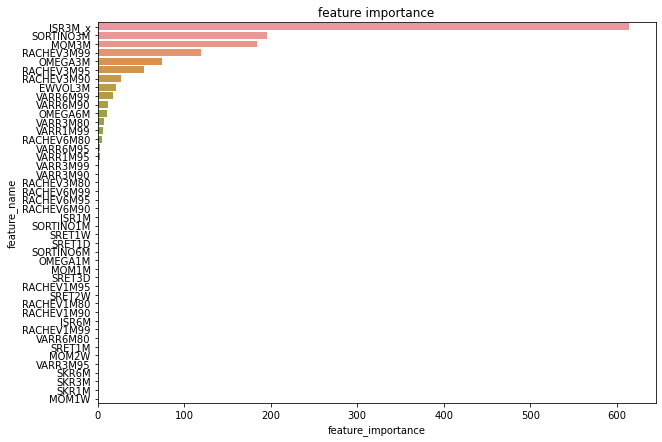

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# feature imporance
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': X_train.columns.tolist(), 'feature_importance': best_ranker.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')

In [44]:
predictions = pd.DataFrame(test[["Date","symbols"]])
predictions["gain"] = best_ranker.predict(X_test)

In [45]:
predictions

,Date,symbols,gain
0,2019-01-01,AUD,-0.454171
1,2019-01-01,CAD,-0.459790
2,2019-01-01,CHF,-0.258354
3,2019-01-01,DKK,-0.419105
4,2019-01-01,GBP,-0.454171
...,...,...,...
9765,2022-09-29,JPY,-0.337370
9766,2022-09-29,NOK,-0.413487
9767,2022-09-29,NZD,-0.454171
9768,2022-09-29,SEK,-0.454171


In [46]:
fx_rates = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [47]:
score_predictions = pd.pivot(
    predictions,
    index="Date",
    columns="symbols",
    values="gain"
).rank(axis=1)

In [283]:
score_predictions

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,3.5,1.5,7.0,5.0,3.5,10.0,1.5,8.0,9.0,6.0
2019-01-02,5.0,1.0,7.0,4.0,3.0,10.0,2.0,9.0,8.0,6.0
2019-01-03,5.0,3.0,8.0,4.0,2.0,10.0,1.0,9.0,7.0,6.0
2019-01-04,5.0,3.0,7.0,4.0,2.0,10.0,1.0,9.0,8.0,6.0
2019-01-07,5.0,2.5,7.0,4.0,1.0,9.0,2.5,10.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,7.0,8.0,9.0,5.0,1.5,6.0,4.0,3.0,1.5,10.0
2022-09-26,7.0,8.0,9.0,5.0,1.0,6.0,4.0,3.0,2.0,10.0
2022-09-27,6.0,8.0,9.0,5.0,1.0,7.0,4.0,2.5,2.5,10.0


In [48]:
mask_best = (score_predictions==10).shift(1)
mask_worst = (score_predictions==1).shift(1)
mask_top3 = ((score_predictions==10) | (score_predictions==9) | (score_predictions==8)).shift(1)
mask_top2 = ((score_predictions==10) | (score_predictions==9)).shift(1)


<AxesSubplot:title={'center':'LambdaMART for Rank Currencies'}, xlabel='Date'>

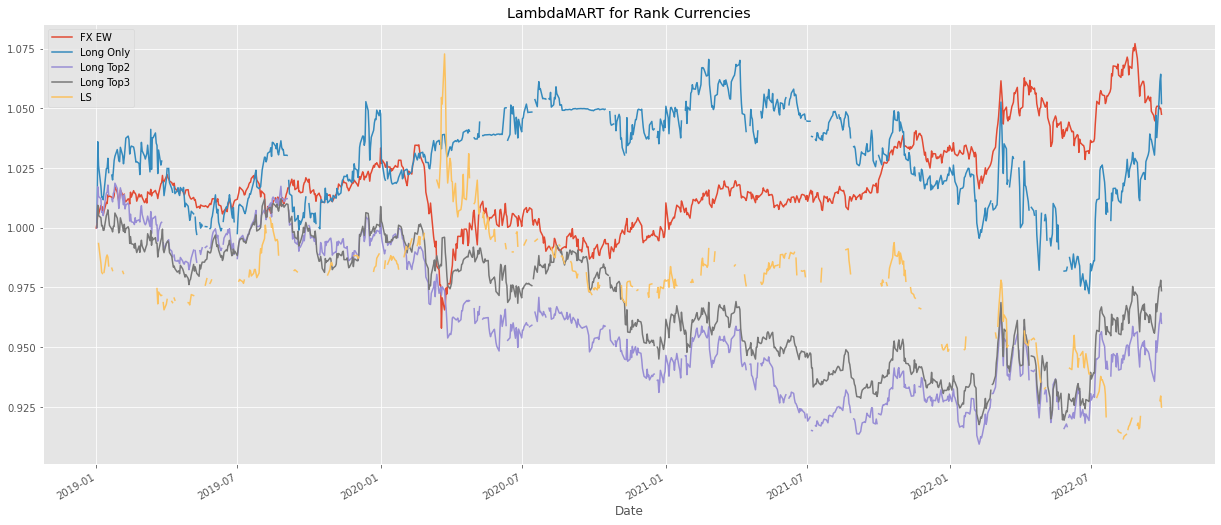

In [67]:
plt.style.use("ggplot")

(1+fx_rates.pct_change()[mask_best.index[0]:].mean(axis=1,skipna=True)).rename("FX EW").cumprod().plot(figsize=(21,9), legend=True, title="LambdaMART for Rank Currencies")

(1+fx_rates.pct_change()[mask_best.index[0]:][mask_best].mean(axis=1)).rename("Long Only").cumprod().plot(figsize=(21,9), legend=True) 
(1+fx_rates.pct_change()[mask_best.index[0]:][mask_top2].mean(axis=1)).rename("Long Top2").cumprod().plot(figsize=(21,9), legend=True)
(1+fx_rates.pct_change()[mask_best.index[0]:][mask_top3].mean(axis=1)).rename("Long Top3").cumprod().plot(figsize=(21,9), legend=True)

(1+0.5*fx_rates.pct_change()[mask_best.index[0]:][mask_best].mean(axis=1,skipna=True)-0.5*fx_rates.pct_change()[mask_best.index[0]:][mask_worst].mean(axis=1,skipna=True)).cumprod().rename("LS").plot(figsize=(21,9), legend=True)

In [50]:
## Acuracy on Rank. Observed (One-Day Ahead) Rank
accuracy_rank = targets[["symbols","ISR3M"]].rename(
    columns={"ISR3M": "observed_rank"}
    )

accuracy_rank

,symbols,observed_rank
Date,,
2004-05-24,AUD,2
2004-05-24,CAD,5
2004-05-24,CHF,9
2004-05-24,DKK,8
2004-05-24,GBP,3
...,...,...
2022-09-29,JPY,6
2022-09-29,NOK,1
2022-09-29,NZD,3


In [51]:
score_predictions_wide = score_predictions.copy()
""" del accuracy_rankers_ts, score_predictions
import gc
gc.collect() """

' del accuracy_rankers_ts, score_predictions\nimport gc\ngc.collect() '

In [52]:
#Melting LambdaMART Predictions
score_predictions_tidy = (
     pd.melt(
        score_predictions_wide,
        value_name="LM_rank",
        ignore_index=False
    )
    .reset_index()
    .sort_values(by=["Date","symbols"])
    .set_index("Date")
    .astype({"LM_rank": "int8"})
)

In [53]:
score_predictions_tidy

,symbols,LM_rank
Date,,
2019-01-01,AUD,3
2019-01-01,CAD,1
2019-01-01,CHF,7
2019-01-01,DKK,5
2019-01-01,GBP,3
...,...,...
2022-09-29,JPY,6
2022-09-29,NOK,4
2022-09-29,NZD,2


In [54]:
accuracy_rankers_ts = (
    pd.merge(
        accuracy_rank,
        score_predictions_tidy,
        how="inner",
        on=["Date","symbols"]
        )
        .sort_values(by=["Date","symbols"])
)

In [55]:
# Accuracy on Combinedd Long-Short Trades
accuracy_Long = (
accuracy_rankers_ts.query(
    "observed_rank==10 and LM_rank==10"
    ).shape[0]/
accuracy_rankers_ts.query(
    "observed_rank==10"
    ).shape[0]
)
print(f"LambdaMART Rank Accuracy on Long Only Bets {100*accuracy_Long:.1f}%")

accuracy_LS = (
accuracy_rankers_ts.query(
    "observed_rank==10 and LM_rank==10 or observed_rank==1 and LM_rank==1"
    ).shape[0]/
accuracy_rankers_ts.query(
    "observed_rank==10 or observed_rank==1"
    ).shape[0]
)

print(f"LambdaMART Rank Accuracy on Long-Short Bets {100*accuracy_LS:.1f}%")

LambdaMART Rank Accuracy on Long Only Bets 79.8%
LambdaMART Rank Accuracy on Long-Short Bets 76.6%


In [63]:
accuracy_rankers_ts.query("observed_rank>7 and LM_rank>7")[["LM_rank"]].describe()

,LM_rank
count,2574.000000
mean,9.054002
std,0.808403
min,8.000000
25%,8.000000
50%,9.000000
75%,10.000000
max,10.000000


In [61]:
100*2574/(977*3)

87.81985670419652

**Some Concluding Remarks**:

1. `LGMBRanker` pairwise ranker does not provide a userful ranking: there's a big difference with the `Oracle` strategy even before transactions costs accounting.
2. `Random` Strategies are not significantly different from the ranked ones (`RtR` or `LETOR`).

4. In sum, it is not clear that this base portfolio could be outperformed by letor-based currency picking for the G11 countries and train-test set split considered.